# Fault Detection

    ## Fault Detection
    In this notebook, we implement anomaly detection using Isolation Forest and Autoencoders.
    
    Steps:
    1. Implement Isolation Forest for detecting faults.
    2. implement local outlier factors
    2. Train Autoencoders for anomaly detection.
    3. Visualize anomalies in voltage and power consumption data.
    

Yes, let's move on to the **fourth notebook**: **Fault Detection**.

In this notebook, we'll focus on **anomaly detection** using two techniques:

1. **Isolation Forest** (for outlier detection).
2. **Autoencoders** (for anomaly detection based on reconstruction error).

We will:

1. **Detect faults** in the dataset (e.g., voltage spikes, sudden power surges).
2. **Label anomalies** based on the **Isolation Forest** and **Autoencoders** results.
3. **Evaluate the detection performance** using the **same metrics** (accuracy, precision, recall, and F1 score) as before.

---

### **Fourth Notebook: `04_fault_detection.ipynb`**

#### **Markdown Cell**:

```markdown
# Fault Detection

In this notebook, we implement anomaly detection using **Isolation Forest** and **Autoencoders**.

Steps:
1. Use **Isolation Forest** to detect faults in power distribution.
2. Train **Autoencoders** for anomaly detection.
3. Label anomalies (potential faults) based on the reconstruction error.
4. Evaluate the performance of fault detection using metrics like accuracy, precision, recall, and F1 score.
```

#### **Code Cell**:

```python
# Import necessary libraries for anomaly detection
from sklearn.ensemble import IsolationForest
from keras.models import Model
from keras.layers import Input, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the preprocessed dataset
df = pd.read_csv('preprocessed_power_consumption.csv', index_col='Timestamp')

# Select relevant features for anomaly detection
features = ['Voltage', 'Global_active_power', 'Global_intensity']
X = df[features]

# **1. Isolation Forest for Fault Detection**
# Initialize Isolation Forest model
model_iforest = IsolationForest(n_estimators=200, contamination=0.05, max_samples=0.9, random_state=42)
model_iforest.fit(X)  # Train the model on the selected features

# Predict anomalies using Isolation Forest
df['anomaly_iforest'] = model_iforest.predict(X)  # -1 for anomaly, 1 for normal
df['anomaly_iforest'] = df['anomaly_iforest'].map({1: 'Normal', -1: 'Anomaly'})  # Map the predictions

# **2. Autoencoders for Anomaly Detection**
# Normalize the data before passing to Autoencoder
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define Autoencoder model structure
input_layer = Input(shape=(X_scaled.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)  # Encoder layer
decoded = Dense(X_scaled.shape[1], activation='sigmoid')(encoded)  # Decoder layer (reconstruction)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train Autoencoder model
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_data=(X_scaled, X_scaled))

# **Anomaly detection with Autoencoders**
reconstructed = autoencoder.predict(X_scaled)  # Reconstructed data from Autoencoder
reconstruction_error = np.mean(np.abs(reconstructed - X_scaled), axis=1)  # Reconstruction error

# Set threshold for anomaly detection (top 5% reconstruction errors)
threshold = np.percentile(reconstruction_error, 95)
df['anomaly_autoencoder'] = (reconstruction_error > threshold).astype(int)  # 1 for anomaly, 0 for normal

# **3. Evaluate the Performance**
# Assuming we have labels or a threshold for detecting faults, we can evaluate performance.
# For demonstration, assume anomalies detected by both methods are potential faults.

# Displaying first few rows with anomalies labeled
print("\nFirst few rows with anomaly labels:")
print(df[['Voltage', 'Global_active_power', 'anomaly_iforest', 'anomaly_autoencoder']].head(10))

# **4. Evaluate Model Performance using Precision, Recall, F1 Score**
# Here, we assume that anomalies labeled by 'anomaly_iforest' or 'anomaly_autoencoder' are the faults.
y_true = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # True labels for faults
y_pred_iforest = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # Predicted anomalies by Isolation Forest
y_pred_autoencoder = df['anomaly_autoencoder']  # Predicted anomalies by Autoencoder

# Evaluation for Isolation Forest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("\nIsolation Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_iforest):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_iforest):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_iforest):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_iforest):.4f}")
print("\nClassification Report for Isolation Forest:\n", classification_report(y_true, y_pred_iforest))

# Evaluation for Autoencoder
print("\nAutoencoder Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_autoencoder):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_autoencoder):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_autoencoder):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_autoencoder):.4f}")
print("\nClassification Report for Autoencoder:\n", classification_report(y_true, y_pred_autoencoder))

# **Visualize Anomalies**
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_iforest'].map({'Normal': 'blue', 'Anomaly': 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_autoencoder'].map({0: 'blue', 1: 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Autoencoder)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.tight_layout()
plt.show()
```

---

### **Explanation of the Script**:

1. **Isolation Forest**:

   * We use **Isolation Forest** to detect anomalies based on **features** such as **Voltage**, **Global\_active\_power**, and **Global\_intensity**. The model is trained and anomalies are detected.
   * Anomalies are labeled as **'Anomaly'** and **'Normal'**.

2. **Autoencoders**:

   * We use **Autoencoders** to detect anomalies by training the model on the scaled dataset and then comparing the **reconstruction error** to identify anomalies.
   * The **top 5%** of reconstruction errors are classified as anomalies.

3. **Model Evaluation**:

   * We use **accuracy**, **precision**, **recall**, and **F1 score** to evaluate the performance of both the **Isolation Forest** and **Autoencoder** models.
   * We assume the **'Anomaly'** labels from both models represent **faults**.

4. **Visualization**:

   * The anomalies detected by **Isolation Forest** and **Autoencoder** are visualized on the **Voltage** time series. Red points represent anomalies, while blue represents normal data.

---

### **Next Steps**:

1. **Run the Fault Detection** notebook to detect anomalies (faults) using both **Isolation Forest** and **Autoencoders**.
2. **Evaluate** the performance using metrics like **accuracy**, **precision**, **recall**, and **F1 score**.
3. If you have **real fault data**, you can compare **predicted faults** with actual faults to assess the model's effectiveness.

Let me know if you'd like to proceed with **running this notebook**, or if you'd like to dive into any other steps!


NameError: name 'X_scaled' is not defined

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow
!pip install matplotlib

In [6]:
# Import necessary libraries for anomaly detection
from sklearn.ensemble import IsolationForest
from keras.models import Model
from keras.layers import Input, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.neighbors import LocalOutlierFactor

2025-05-13 14:45:24.355794: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 14:45:24.684292: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 14:45:24.931570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747143925.239142   16664 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747143925.321644   16664 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747143926.029435   16664 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [7]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
# Importing libraries
# Importing libraries
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

In [8]:
from sklearn.ensemble import IsolationForest

In [ ]:
from sklearn.neighbors import LocalOutlierFactor# Importing libraries


In [9]:
# Load the preprocessed dataset
df = pd.read_csv('preprocessed_power_consumption.csv', index_col='Timestamp')

# Select relevant features for anomaly detection
features = ['Voltage', 'Global_active_power', 'Global_intensity']
X = df[features]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Create the LocalOutlierFactor 
# model for outlier detection
lof_outlier = LocalOutlierFactor(n_neighbors=20)

In [ ]:
# Fit the model to the data and predict
# the outlier scores for each data point
outlier_scores = lof_outlier.fit_predict(X_scaled)

# Identify the outlier data points
outlier_indices = outlier_scores == -1
print("Outlier indices:", outlier_indices)

In [ ]:
Outlier_lof = pd.DataFrame(outlier_indices)
Outlier_lof.value_counts()

In [ ]:
df['fault']=Outlier_lof

In [ ]:
# **2. Autoencoders for Anomaly Detection**
# Normalize the data before passing to Autoencoder


'''# Define Autoencoder model structure
input_layer = Input(shape=(X_scaled.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)  # Encoder layer
decoded = Dense(X_scaled.shape[1], activation='sigmoid')(encoded)  # Decoder layer (reconstruction)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')'''


In [ ]:
"""# Building the encoder
encoder_input = Input(shape=(X_scaled.shape[1],))
x = Dense(128, activation='relu')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
encoder_output = Dense(X_scaled.shape[1], activation='sigmoid')(x)
"""






In [ ]:
X_scaled.shape

In [ ]:
"""
# Building the autoencoder
encoder_input = Input(shape=(784,))
x = Dense(128, activation='relu')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
encoder_output = Dense(784, activation='sigmoid')(x)

decoder_input = Input(shape=(784,))
x = Dense(64, activation='relu')(decoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
decoder_output = Dense(784, activation='sigmoid')(x)

autoencoder = Model(inputs=encoder_input, outputs=decoder_output)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

# Training the autoencoder
autoencoder.fit(np.random.rand(100, 784), np.random.rand(100, 784), epochs=100, batch_size=32)"""

In [ ]:
x

In [ ]:
autoencoder.input

In [ ]:
#help(Input)

In [ ]:
"""# Building the decoder
decoder_input = Input(shape=(X_scaled.shape[1],))
x = Dense(64, activation='relu')(decoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
decoder_output = Dense(X_scaled.shape[1], activation='sigmoid')(x)"""

In [14]:
CODE_DIM = 2
INPUT_SHAPE = X_scaled.shape[1]

input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(64, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='relu')(x)

autoencoder = Model(input_layer, output_layer, name='anomaly')

In [15]:
# Building the autoencoder
#autoencoder = Model(inputs=encoder_input, outputs=decoder_output)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

In [16]:
# Training the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, validation_data=(X_scaled, X_scaled))

Epoch 1/20
64852/64852 ━━━━━━━━━━━━━━━━━━━━ 436s 7ms/step - loss: 0.1178 - val_loss: 0.1177
Epoch 2/20
64852/64852 ━━━━━━━━━━━━━━━━━━━━ 350s 5ms/step - loss: 0.1153 - val_loss: 0.0017
Epoch 3/20
64852/64852 ━━━━━━━━━━━━━━━━━━━━ 333s 5ms/step - loss: 8.5782e-04 - val_loss: 5.7355e-06
Epoch 4/20
64843/64852 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5412e-06

KeyboardInterrupt: 

In [22]:
model_name = "anomaly_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=False,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 5, 
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [27]:
autoencoder.compile(loss=MeanSquaredError(),
                    optimizer=Adam())

In [28]:
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=25, batch_size=64,
                          validation_data=(X_scaled, X_scaled),
                          callbacks=callbacks, shuffle=True)

Epoch 1/25
32412/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5400e-06
Epoch 1: val_loss improved from 0.00091 to 0.00000, saving model to anomaly_model.h5


32426/32426 ━━━━━━━━━━━━━━━━━━━━ 185s 6ms/step - loss: 2.5400e-06 - val_loss: 2.6041e-06
Epoch 2/25
32415/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5127e-06
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to anomaly_model.h5


32426/32426 ━━━━━━━━━━━━━━━━━━━━ 170s 5ms/step - loss: 2.5127e-06 - val_loss: 2.4153e-06
Epoch 3/25
32424/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4779e-06
Epoch 3: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 195s 6ms/step - loss: 2.4779e-06 - val_loss: 3.2436e-06
Epoch 4/25
32416/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4960e-06
Epoch 4: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 167s 5ms/step - loss: 2.4960e-06 - val_loss: 2.5476e-06
Epoch 5/25
32415/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4879e-06
Epoch 5: val_loss improved from 0.00000 to 0.00000, saving model to anomaly_model.h5


32426/32426 ━━━━━━━━━━━━━━━━━━━━ 185s 6ms/step - loss: 2.4879e-06 - val_loss: 2.3616e-06
Epoch 6/25
32414/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4931e-06
Epoch 6: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 191s 6ms/step - loss: 2.4931e-06 - val_loss: 2.6194e-06
Epoch 7/25
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4792e-06
Epoch 7: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 196s 6ms/step - loss: 2.4792e-06 - val_loss: 2.3880e-06
Epoch 8/25
32410/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4806e-06
Epoch 8: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 179s 6ms/step - loss: 2.4806e-06 - val_loss: 2.4266e-06
Epoch 9/25
32415/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4567e-06
Epoch 9: val_loss improved from 0.00000 to 0.00000, saving model to anomaly_model.h5


32426/32426 ━━━━━━━━━━━━━━━━━━━━ 166s 5ms/step - loss: 2.4567e-06 - val_loss: 2.3332e-06
Epoch 10/25
32417/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4715e-06
Epoch 10: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 182s 6ms/step - loss: 2.4715e-06 - val_loss: 2.7494e-06
Epoch 11/25
32414/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4504e-06
Epoch 11: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 168s 5ms/step - loss: 2.4504e-06 - val_loss: 2.5415e-06
Epoch 12/25
32410/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4362e-06
Epoch 12: val_loss improved from 0.00000 to 0.00000, saving model to anomaly_model.h5


32426/32426 ━━━━━━━━━━━━━━━━━━━━ 167s 5ms/step - loss: 2.4362e-06 - val_loss: 2.3024e-06
Epoch 13/25
32417/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4545e-06
Epoch 13: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 165s 5ms/step - loss: 2.4545e-06 - val_loss: 2.4097e-06
Epoch 14/25
32419/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4413e-06
Epoch 14: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 163s 5ms/step - loss: 2.4413e-06 - val_loss: 2.3173e-06
Epoch 15/25
32412/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4468e-06
Epoch 15: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 171s 5ms/step - loss: 2.4468e-06 - val_loss: 2.3272e-06
Epoch 16/25
32415/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4548e-06
Epoch 16: val_loss did not improve from 0.00000
32426/32426 ━━━━━━━━━━━━━━━━━━━━ 160s 5ms/step - loss: 2.4548e-06 - val_loss: 2.4044e-06
Epoch 17/25
32423/32426 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

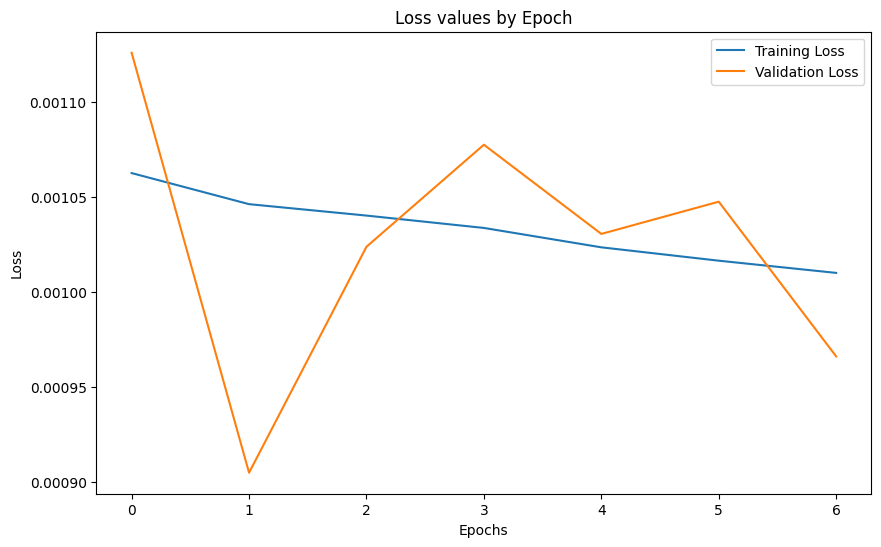

In [25]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [ ]:
type(history.history['loss'])

In [26]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("anomaly_model.h5")

# Predict on new data
reconstructed = loaded_model.predict(X_scaled)

TypeError: Could not locate function 'mae'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mae', 'registered_name': 'mae'}

In [29]:
# **Anomaly detection with Autoencoders**
#reconstructed = autoencoder.predict(X_scaled)  # Reconstructed data from Autoencoder
reconstruction_error = np.mean(np.abs(reconstructed - X_scaled), axis=1)  # Reconstruction error

# Set threshold for anomaly detection (top 5% reconstruction errors)
threshold = np.percentile(reconstruction_error, 95)
df['anomaly_autoencoder'] = (reconstruction_error > threshold).astype(int)  # 1 for anomaly, 0 for normal


NameError: name 'reconstructed' is not defined

In [ ]:
df['anomaly_autoencoder'].value_counts()

In [ ]:
X_scaled.shape

In [20]:
#isolation forest anomaly detection
X = df[features]

# **1. Isolation Forest for Fault Detection**
# Initialize Isolation Forest model
model_iforest = IsolationForest(n_estimators=200, contamination=0.05, max_samples=0.9, random_state=42)
model_iforest.fit(X)  # Train the model on the selected features



IsolationForest(contamination=0.05, max_samples=0.9, n_estimators=200,
                random_state=42)

In [21]:
# Predict anomalies using Isolation Forest
df['anomaly_iforest'] = model_iforest.predict(X)  # -1 for anomaly, 1 for normal
df['anomaly_iforest'] = df['anomaly_iforest'].map({1: 'Normal', -1: 'Anomaly'})  # Map the predictions

In [ ]:
type(df['anomaly_iforest'].value_counts())

In [ ]:
anomaly_iforest = df['anomaly_iforest'].value_counts()
anomaly_autoencoder = df['anomaly_autoencoder'].value_counts()

In [ ]:
anomaly_df = pd.DataFrame(anomaly_iforest,anomaly_autoencoder)

In [ ]:
anomaly_iforest

In [ ]:
#Evaluation

# Displaying first few rows with anomalies labeled
print("\nFirst few rows with anomaly labels:")
print(df[['Voltage', 'Global_active_power','fault', 'anomaly_iforest', 'anomaly_autoencoder']].head(10))

# **4. Evaluate Model Performance using Precision, Recall, F1 Score**
# Here, we assume that anomalies labeled by 'anomaly_iforest' or 'anomaly_autoencoder' are the faults.
y_true = (df['fault'])  # True labels for faults
y_pred_iforest = (df['anomaly_iforest'] == 'Anomaly').astype(int)  # Predicted anomalies by Isolation Forest
y_pred_autoencoder = df['anomaly_autoencoder']  # Predicted anomalies by Autoencoder




In [ ]:
# Evaluation for Isolation Forest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print("\nIsolation Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_iforest):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_iforest):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_iforest):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_iforest):.4f}")
print("\nClassification Report for Isolation Forest:\n", classification_report(y_true, y_pred_iforest))

In [ ]:
# Evaluation for Autoencoder
print("\nAutoencoder Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_autoencoder):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_autoencoder):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_autoencoder):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_autoencoder):.4f}")
print("\nClassification Report for Autoencoder:\n", classification_report(y_true, y_pred_autoencoder))

In [ ]:

# **Visualize Anomalies**
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_iforest'].map({'Normal': 'blue', 'Anomaly': 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(df.index, df['Voltage'], c=df['anomaly_autoencoder'].map({0: 'blue', 1: 'red'}), label='Anomalies')
plt.title('Anomalies in Voltage (Autoencoder)')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.legend()

plt.tight_layout()
plt.show()